# FVM

This notebook is an implementation of vanilla 2-D FVM with Cartesian mesh of arbitrary width. In a nutshell:
1. Start with the conservative form (without emission)
2. Cast the transport equation into the integral form
3. Solve integral form using FV

In FV, we construct a mesh of finitely many volumes, and assume that the density is constant on each mesh cell, i.e. the density is piecewise constant.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import ode

# 1. 1-D Finite Volume

## 1.1 Central Flux Scheme

Here we introduce RTE flux into 1-D finite volume scheme. Here we solve the radiation transport equation in vacuum:

$$ \frac{1}{c} \partial_t I_{\mu} + (\textbf{n} \cdot \nabla) I_{\mu} = 0 $$

In [6]:
# 1-D Finite Volume
# define setup variables

NUM_CELLS = 50
MAX_X = 1
MIN_X = 0

# initialize the grid
x = np.linspace(MIN_X, MAX_X, NUM_CELLS + 1)

In [7]:
def centralFlux(I):
    """
    1-D Finite Volume
    Central Flux Scheme for FV
    Assuming Periodic Boundary Condition, ignoring constant c
    """
    
    n = len(I)
    dx = 1/n
    
    # to interpolate intensity at the mid of grid
    I_off = np.hstack((I[1:], I[0]))
    I_mid = (I + I_off) / 2
    
    # to accumulate flux
    flux = I_mid # radiation flux
    temp = - flux
    temp[1:] = temp[1:] + flux[:-1]
    temp[0] = temp[0] + flux[-1]
    
    return temp / dx

In [8]:
I_init = - np.cos(2 * np.pi * x)/(2 * np.pi) # assume sine initial condition (the integral is minus cosine)
I_init = (I_init[1:] - I_init[:-1]) * NUM_CELLS # division over volume = multiplied by grids

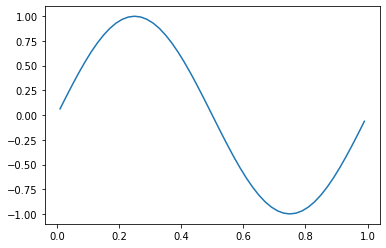

In [9]:
plt.plot((x[1:] + x[:-1]) * 0.5 , I_init)

Time 0.1
Time 0.2


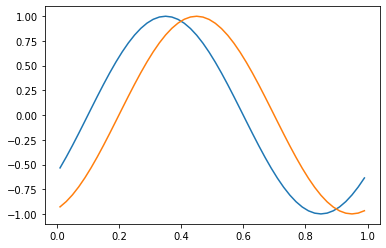

In [10]:
# integrate with RK45
r = ode(lambda t, x: centralFlux(x)).set_integrator('dopri5')
r.set_initial_value(I_init, 0)
t1 = 0.2 # let's check for short period
dt = 0.1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    print("Time %g" % (r.t))
    #fig = plt.figure()
    #ax = fig.add_axes([0, 0, 1, 1])
    plt.plot((x[1:] + x[:-1]) * 0.5, r.y)

## 1.2 Matrix Scheme

### 1.2.1 Emission

Here we work with the stationary version of the RTE:

$$ (\textbf{n} \cdot \nabla) I_{\mu} = q_{\mu}$$

Casting this into integral form in 1-D, for $i = 1,..., n-1$ grid cells we have

$$ \rho_i - \rho_{i-1} = \int_{V_i} q \,dx $$

so that we get a linear system $ A\psi = q$. On the leftmost cell we have $-\rho_{inc}$. Assume initial condition $\rho_{inc} = 0$.

In [3]:
# 1-D Finite Volume
# define setup variables

NUM_CELLS = 50 # define number of grid cells

# define computational domain
MAX_X = 1
MIN_X = 0

# initialize the grid
x = np.linspace(MIN_X, MAX_X, NUM_CELLS + 1)

In [4]:
# define the source term
q_v = np.ones(NUM_CELLS) * (MAX_X - MIN_X)/NUM_CELLS
q_v

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

In [5]:
# define the operator matrix 

A = np.identity(NUM_CELLS)
for i in range(NUM_CELLS):
    if i < (NUM_CELLS - 1):
        A[i + 1, i] = -1
A

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

Text(0, 0.5, 'density')

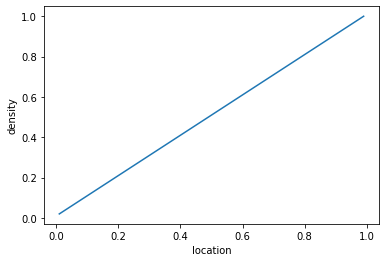

In [10]:
# solve for the density
rho = np.linalg.solve(A, q_v)

x_off = np.hstack((x[1:], x[0]))
x_mid = (x + x_off)/2
x_mid = x_mid[:-1]

plt.plot(x_mid, rho)
plt.xlabel("location")
plt.ylabel("density")

### 1.2.2 Absorption and Scattering

# 2. 2-D Finite Volume

For now assume isotropic grid.

In [88]:
# 2-D Finite Volume
# define setup variables

NUM_CELLS_X = 50
NUM_CELLS_Y = 50
MIN_X = 0
MAX_X = 1
MIN_Y = 0
MAX_Y = 1
THETA = 0

In [89]:
# compute auxiliary variables

dx = (MAX_X - MIN_X)/NUM_CELLS_X
dy = (MAX_Y - MIN_Y)/NUM_CELLS_Y

In [90]:
# define the matrix operator
A = np.zeros((NUM_CELLS_X**2, NUM_CELLS_Y**2))

for i in range(NUM_CELLS_X * NUM_CELLS_Y):
    for j in range(NUM_CELLS_X * NUM_CELLS_Y):
        if i == j:
            A[i][j] += np.sin(THETA) + np.cos(THETA)
            if ((j) % NUM_CELLS_X) != 0: # detect the leftmost cells
                A[i][j-1] += -np.sin(THETA)
            if j+1 > NUM_CELLS_X: # detect the bottommost cells
                A[i][j-NUM_CELLS_X] += -np.cos(THETA)
            
A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [91]:
q_v = np.ones(NUM_CELLS_X * NUM_CELLS_Y) * (MAX_X - MIN_X)/NUM_CELLS_X
q_v

array([0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02])

In [92]:
rho = np.linalg.solve(A, q_v)

rho

array([0.02, 0.02, 0.02, ..., 1.  , 1.  , 1.  ])

In [93]:
z = np.zeros((NUM_CELLS_X,NUM_CELLS_X))
for i in range(NUM_CELLS_X):
    for j in range(NUM_CELLS_X):
        z[i][j] = rho[(i*NUM_CELLS_X)+j]
        
z

array([[0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       [0.06, 0.06, 0.06, ..., 0.06, 0.06, 0.06],
       ...,
       [0.96, 0.96, 0.96, ..., 0.96, 0.96, 0.96],
       [0.98, 0.98, 0.98, ..., 0.98, 0.98, 0.98],
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ]])

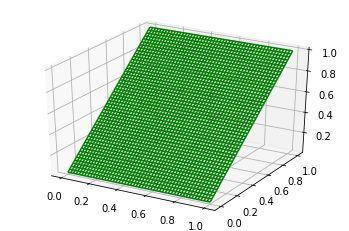

In [94]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection = "3d")
x_line = np.linspace(0,MAX_X, NUM_CELLS_X)
y_line = np.linspace(0,MAX_Y, NUM_CELLS_X)

X, Y = np.meshgrid(x_line, y_line)
ax.plot_wireframe(X, Y, z, color='green')

In [31]:
A = np.ones((NUM_CELLS_X**2, NUM_CELLS_Y**2))

for i in range(NUM_CELLS_X):
    for j in range(NUM_CELLS_Y):
        A[(i-1) * NUM_CELLS_X + j][(i-1) * NUM_CELLS_X + j] = 0
        
A

array([[0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0.]])